In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
import xgboost as xgb
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.options.display.float_format = '{:,.2f}'.format

In [3]:
data = pd.read_csv(
    'dataset_wparticipant_v2.csv',
    delimiter=';',
    dtype=str,
    usecols=[
        "lot_id",
        "fw_total_price_wdiscount",
        "sw_total_price_wdiscount",
        "ad_total_sum",
        "total_amount",

        # integers
        "total_count",        
        "ad_lots_count",

        # binary
        "is_union_lots",
        "is_dumping",
        "is_consulting_services",
        "is_disable_person_advertisement",
        "ad_disable_person_id",
        "ad_purchase_type_id",
        "participant_is_have_website",
        "participant_is_quazi",
        "participant_is_national_company",
        "participant_is_association_with_disabilities",
        "participant_is_supplier",
        "participant_is_state_monopoly",
        "participant_is_natural_monopoly",
        "participant_is_small_employer",
        "participant_is_single_org",
        
        # categorical
        "lot_status_id",
        "plan_trade_method_id",
        "psd_sign",
        "single_org_sign",
        "is_light_industry",
        "is_construction_work",
        "ad_trade_method_id",
        "ad_subject_type_id",
        "ad_trade_type_id",
        "ad_single_org_sign",
        "ad_is_light_industry",
        "ad_is_construction_work",
        "participant_creation_date",
        "participant_registration_year",
        "participant_krp_code",
        "participant_oked_list",
        "participant_kse_code",

        # additional
        "ad_start_date",
        "ad_repeat_start_date",
        "ad_end_date",
        "ad_repeat_end_date",
        "ad_publish_date",

        "ad_fin_years",
        "ad_katos",
        "participant_registration_date",
        "participant_kato_list",
        "participant_kopf_code",
        "participant_branches",
        "participant_parent_company",
        
        # 'customer_id',
        # fact_trade_method_id,
        # plans_ids
        # ad_customer_id - не заполнялось
        # advertisement_status_id - оставили только 350, завершенные закупки
        # ad_itogi_date_public - известно только после окончания закупки
        # participant_id
        # participant_bin
        # participant_iin
        # participant_country - только Казахстан
        # participant_is_organizer
        # participant_is_customer
        # participant_is_resident - не особо заполняется
        # participant_supplier_type - особо не заполняется
        # participant_is_world_company - особо не заполняется
        # participant_is_patronymic_producer - везде одно значение
        # participant_is_patronymic_supplier - везде одно
        
    ]
)
data.head()

,lot_id,fw_total_price_wdiscount,sw_total_price_wdiscount,lot_status_id,is_union_lots,total_count,total_amount,is_dumping,plan_trade_method_id,psd_sign,...,participant_is_supplier,participant_krp_code,participant_branches,participant_parent_company,participant_oked_list,participant_kse_code,participant_is_state_monopoly,participant_is_natural_monopoly,participant_is_small_employer,participant_is_single_org
0,29526032,4160393.3600,4186892.6800,360,0,1,4907281.6200,1,188,18,...,1,0,NaN,NaN,36000,5,0,1,0,0
1,29525894,13900.0000,15900.0000,360,0,100,20000.0000,0,3,0,...,1,0,NaN,NaN,85100,5,0,1,1,0
2,29524214,209999.0000,249000.0000,360,0,1,250000.0000,0,3,0,...,0,0,NaN,NaN,84113,5,0,0,0,0
3,29520431,2400.0000,2790.0000,360,0,30,3000.0000,0,3,0,...,0,0,NaN,NaN,84114,5,0,0,0,0
4,29415829,169000.0000,171600.0000,360,0,5,214285.7000,0,3,0,...,1,0,NaN,NaN,85520,5,0,0,1,0


In [4]:
quantiles = [0.0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]

In [5]:
for numeric_field in (
    "fw_total_price_wdiscount",
    "sw_total_price_wdiscount",
    "ad_total_sum",
    "total_amount",

    "total_count",        
    "ad_lots_count",
):
    data[numeric_field] = pd.to_numeric(data[numeric_field])

In [6]:
data = data[data.lot_status_id == '360'] # ток состоявшиеся лоты

In [7]:
data.loc[data.sw_total_price_wdiscount.isna(), "sw_total_price_wdiscount"] = data.loc[data.sw_total_price_wdiscount.isna(), "total_amount"]

In [8]:
# 1163 rows will be removed; закупки по которым некорректно сидела информация на портале - например спуталось кол-во и цена за один товар, полная цена
data = data[~(data.sw_total_price_wdiscount < data.fw_total_price_wdiscount)]

In [9]:
pd.DataFrame({
    "Quantile": quantiles,
    "fw_total_price_wdiscount": data.fw_total_price_wdiscount.quantile(quantiles)
})

,Quantile,fw_total_price_wdiscount
0.00,0.00,0.00
0.01,0.01,0.00
0.05,0.05,0.00
0.10,0.10,"1,440.00"
0.25,0.25,"9,200.00"
0.50,0.50,"42,000.00"
0.75,0.75,"202,455.00"
0.90,0.90,"1,006,800.00"
0.95,0.95,"3,007,000.00"
0.99,0.99,"24,306,096.39"


In [10]:
data = data[~(data.fw_total_price_wdiscount <= data.fw_total_price_wdiscount.quantile(0.10))] # мы не занимаемся благотворительностью

In [11]:
data = data[~(data.fw_total_price_wdiscount > data.total_amount)] # эти каким-то боком умудрились продать свои услуги дороже чем было выделено из бюджета

In [12]:
pd.DataFrame({
    "Quantile": quantiles,
    "(total_amount / fw_total_price_wdiscount)": (data['total_amount'] / data['fw_total_price_wdiscount']).quantile(quantiles)
})

,Quantile,(total_amount / fw_total_price_wdiscount)
0.00,0.00,1.00
0.01,0.01,1.00
0.05,0.05,1.00
0.10,0.10,1.03
0.25,0.25,1.12
0.50,0.50,1.34
0.75,0.75,1.69
0.90,0.90,2.12
0.95,0.95,2.47
0.99,0.99,3.65


In [13]:
# эти уебки слишком сильно сбрасывают цену, на кол - безосновательно скидывают, изучали. 55к таких
data = data[~((data['total_amount'] / data['fw_total_price_wdiscount']) > (data['total_amount'] / data['fw_total_price_wdiscount']).quantile(0.99))]

In [14]:
len(data[data.fw_total_price_wdiscount == data.total_amount]) / len(data), (data.fw_total_price_wdiscount / data.total_amount).quantile(quantiles)

(0.036225435378726224,
 0.00   0.27
 0.01   0.33
 0.05   0.42
 0.10   0.48
 0.25   0.60
 0.50   0.75
 0.75   0.89
 0.90   0.97
 0.95   1.00
 0.99   1.00
 1.00   1.00
 dtype: float64)

In [15]:
data = data[~(data.fw_total_price_wdiscount == data.total_amount)] #  пока не совсем понятно как с такими записями работать, и сильно ли это повлияет

In [16]:
quantile_values = data['total_amount'].quantile(quantiles)
cumulative_lots = [data['total_amount'].le(value).sum() for value in quantile_values]
lots_in_quantile = np.diff([0] + cumulative_lots)

data['unearned_revenue'] = data['sw_total_price_wdiscount'] - data['fw_total_price_wdiscount']
data['unearned_revenue_pct'] = (data['sw_total_price_wdiscount'] / data['fw_total_price_wdiscount'] - 1) * 100

range_start = [0] + list(quantile_values)[:-1]
range_end = list(quantile_values)

# total unearned revenue within each quantile range
unearned_revenue = []
cumulative_unearned_revenue = []
non_cumulative_unearned_revenue_pct = []
cumulative_sum = 0

for start, end in zip(range_start, range_end):
    unearned_sum = data[(data['total_amount'] > start) & (data['total_amount'] <= end)]['unearned_revenue'].sum()
    unearned_revenue.append(unearned_sum)

    cumulative_sum += unearned_sum
    cumulative_unearned_revenue.append(cumulative_sum)

    avg_pct = data[(data['total_amount'] > start) & (data['total_amount'] <= end)]['unearned_revenue_pct'].quantile(0.667) if not data[(data['total_amount'] > start) & (data['total_amount'] <= end)].empty else 0
    non_cumulative_unearned_revenue_pct.append(avg_pct)

unearned_revenue_summary = pd.DataFrame({
    "Quantile": quantiles,
    "LotQuantileBound": quantile_values,
    "CumulativeLotsCount": cumulative_lots,
    "LotsInQuantile": lots_in_quantile,
    "UnearnedRevenue": unearned_revenue,
    "CumulativeUnearnedRevenue": cumulative_unearned_revenue,
    "NonCumulativeUnearnedRevenueQ66percent": non_cumulative_unearned_revenue_pct
})

unearned_revenue_summary

,Quantile,LotQuantileBound,CumulativeLotsCount,LotsInQuantile,UnearnedRevenue,CumulativeUnearnedRevenue,NonCumulativeUnearnedRevenueQ66percent
0.00,0.00,"1,446.40",1,1,0.10,0.10,0.01
0.01,0.01,"2,487.50",51660,51659,"8,349,377.89","8,349,377.99",10.71
0.05,0.05,"4,900.00",258325,206665,"82,576,939.63","90,926,317.62",16.79
0.10,0.10,"8,000.00",526750,268425,"191,699,182.56","282,625,500.18",17.65
0.25,0.25,"22,321.45",1291668,764918,"1,112,443,227.98","1,395,068,728.16",16.16
0.50,0.50,"84,000.00",2587652,1295984,"5,203,180,205.78","6,598,248,933.94",13.83
0.75,0.75,"355,000.00",3874671,1287019,"17,669,569,949.99","24,267,818,883.93",12.00
0.90,0.90,"1,692,857.46",4649288,774617,"40,305,141,430.80","64,572,960,314.73",10.61
0.95,0.95,"4,730,567.25",4907582,258294,"43,055,687,577.78","107,628,647,892.51",9.02
0.99,0.99,"35,445,702.14",5114217,206635,"125,839,813,983.59","233,468,461,876.10",7.35


In [17]:
data[
    [
        "sw_total_price_wdiscount",
        "ad_total_sum",
        "total_amount"
    ]
].corr()

# ad_total_sum и total_amount сильно коррелируют, можно исключить одну из них, та что коррелирует меньше с целевой
# таким образом, исключаем ad_total_sum

,sw_total_price_wdiscount,ad_total_sum,total_amount
sw_total_price_wdiscount,1.00,0.73,1.00
ad_total_sum,0.73,1.00,0.73
total_amount,1.00,0.73,1.00


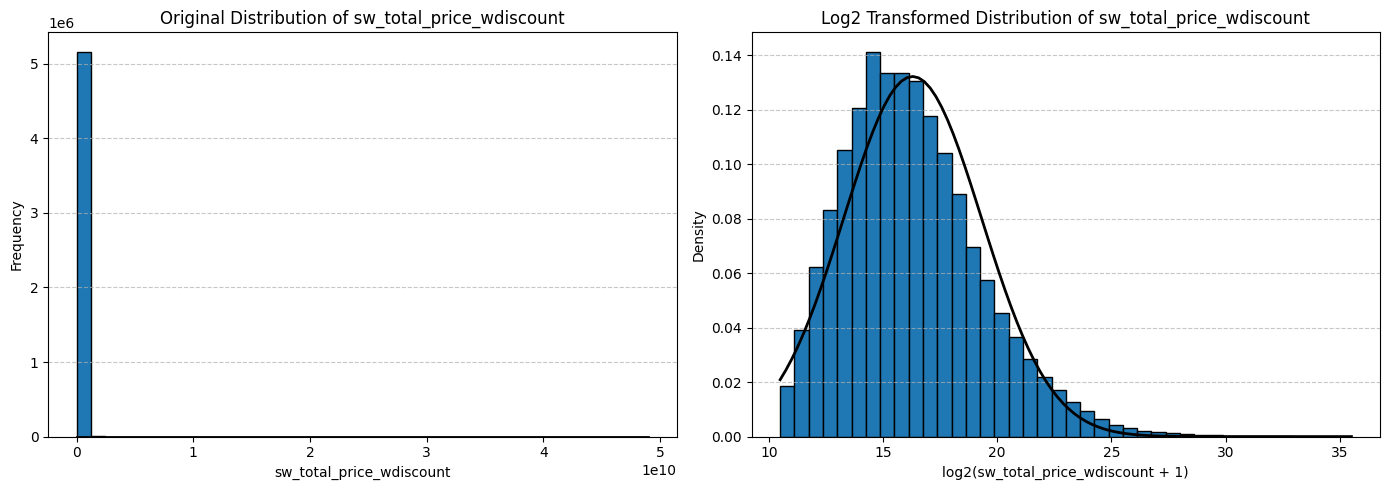

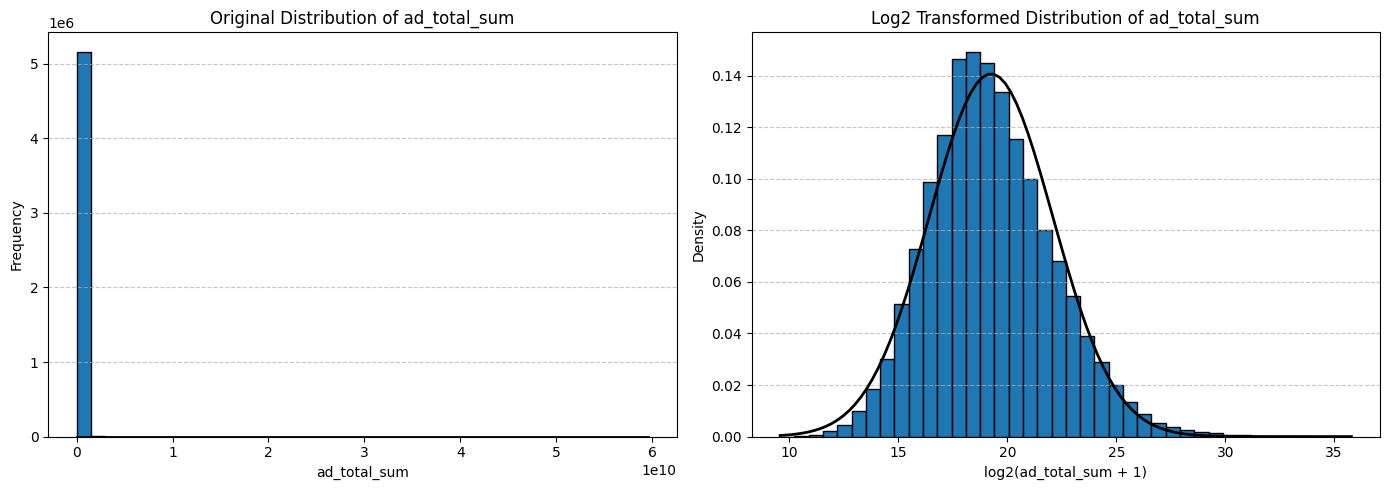

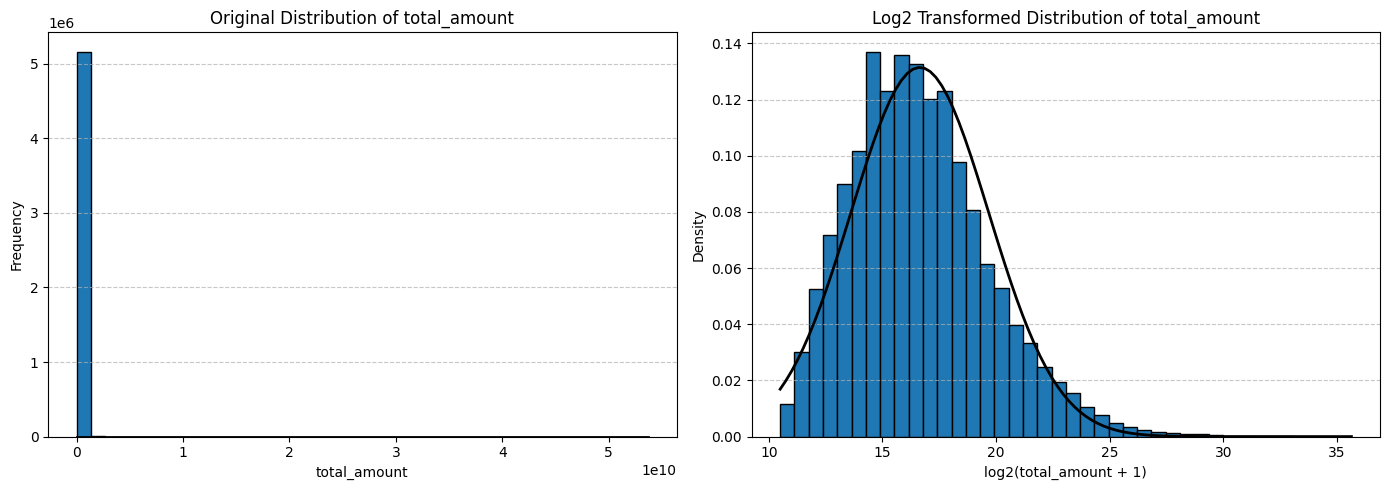

In [19]:
for col in ["sw_total_price_wdiscount", "ad_total_sum", "total_amount"]:
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].hist(data[col], bins=40, edgecolor="black")

    mu, std = norm.fit(data[col])
    x = np.linspace(data[col].min(), data[col].max(), 100)
    p = norm.pdf(x, mu, std)
    ax[0].plot(x, p, 'k', linewidth=2)

    ax[0].set_title(f"Original Distribution of {col}")
    ax[0].set_xlabel(col)
    ax[0].set_ylabel("Frequency")
    ax[0].grid(axis='y', linestyle='--', alpha=0.7)

    # log_data = np.log10(data[col] + 1)
    # ax[1].hist(log_data, bins=40, edgecolor="black", density=True)
    
    # mu, std = norm.fit(log_data)
    # x = np.linspace(log_data.min(), log_data.max(), 100)
    # p = norm.pdf(x, mu, std)
    # ax[1].plot(x, p, 'k', linewidth=2)

    # ax[1].set_title(f"Log10 Transformed Distribution of {col}")
    # ax[1].set_xlabel(f"log10({col} + 1)")
    # ax[1].set_ylabel("Frequency")
    # ax[1].grid(axis='y', linestyle='--', alpha=0.7)

    
    log2_data = np.log2(data[col] + 1)
    ax[1].hist(log2_data, bins=40, edgecolor="black", density=True)
    mu, std = norm.fit(log2_data)
    x = np.linspace(log2_data.min(), log2_data.max(), 100)
    p = norm.pdf(x, mu, std)
    ax[1].plot(x, p, 'k', linewidth=2)
    ax[1].set_title(f"Log2 Transformed Distribution of {col}")
    ax[1].set_xlabel(f"log2({col} + 1)")
    ax[1].set_ylabel("Density")
    ax[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

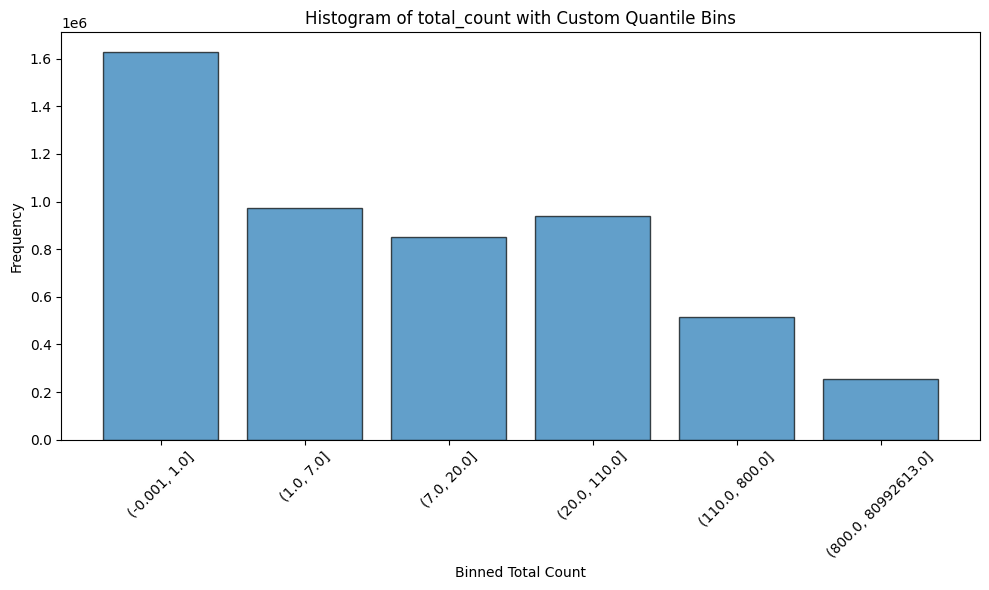

(      Quantile         Bound
 0.00      0.00          0.00
 0.01      0.01          1.00
 0.05      0.05          1.00
 0.10      0.10          1.00
 0.25      0.25          1.00
 0.50      0.50          7.00
 0.75      0.75         50.00
 0.90      0.90        250.00
 0.95      0.95        800.00
 0.99      0.99      6,675.00
 1.00      1.00 80,992,613.00,
            total_count    count
 0        (-0.001, 1.0]  1629355
 1           (1.0, 7.0]   972327
 2          (7.0, 20.0]   852152
 3        (20.0, 110.0]   941008
 4       (110.0, 800.0]   514796
 5  (800.0, 80992613.0]   256238)

In [20]:
quantile_bins = np.unique(data['total_count'].quantile([0.0, 0.05, 0.5, 0.65, 0.85, 0.95, 1]))
bin_counts = pd.cut(data['total_count'], bins=quantile_bins, include_lowest=True).value_counts(sort=False).reset_index()


plt.figure(figsize=(10, 6))
plt.bar(
    bin_counts['total_count'].astype(str), bin_counts['count'], edgecolor='black', alpha=0.7
)
plt.xticks(rotation=45)
plt.title("Histogram of total_count with Custom Quantile Bins")
plt.xlabel("Binned Total Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


pd.DataFrame({
    "Quantile": quantiles,
    "Bound": data['total_count'].quantile(quantiles)
}), bin_counts

In [21]:
data[~data.participant_is_quazi.isna()]

,lot_id,fw_total_price_wdiscount,sw_total_price_wdiscount,lot_status_id,is_union_lots,total_count,total_amount,is_dumping,plan_trade_method_id,psd_sign,...,participant_branches,participant_parent_company,participant_oked_list,participant_kse_code,participant_is_state_monopoly,participant_is_natural_monopoly,participant_is_small_employer,participant_is_single_org,unearned_revenue,unearned_revenue_pct
0,29526032,"4,160,393.36","4,186,892.68",360,0,1,"4,907,281.62",1,188,18,...,NaN,NaN,36000,5,0,1,0,0,"26,499.32",0.64
1,29525894,"13,900.00","15,900.00",360,0,100,"20,000.00",0,3,0,...,NaN,NaN,85100,5,0,1,1,0,"2,000.00",14.39
2,29524214,"209,999.00","249,000.00",360,0,1,"250,000.00",0,3,0,...,NaN,NaN,84113,5,0,0,0,0,"39,001.00",18.57
3,29520431,"2,400.00","2,790.00",360,0,30,"3,000.00",0,3,0,...,NaN,NaN,84114,5,0,0,0,0,390.00,16.25
4,29415829,"169,000.00","171,600.00",360,0,5,"214,285.70",0,3,0,...,NaN,NaN,85520,5,0,0,1,0,"2,600.00",1.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6034216,29546364,"21,800.00","28,700.00",360,0,100,"45,000.00",0,3,0,...,NaN,NaN,84220,5,0,1,0,0,"6,900.00",31.65
6034217,29538544,"6,960.00","7,000.00",360,0,20,"8,000.00",0,3,0,...,NaN,NaN,84130,5,0,0,0,0,40.00,0.57
6034218,29535140,"42,000.00","52,500.00",360,0,1,"62,500.00",0,3,0,...,NaN,NaN,85310,5,0,0,0,0,"10,500.00",25.00
6034219,29532943,"2,981.00","3,775.00",360,0,1,"3,900.00",0,3,0,...,NaN,NaN,91012,5,0,0,0,0,794.00,26.64


In [22]:
data = data[~data.participant_is_quazi.isna()] # remove 73 rows

group_columns = [
    "is_union_lots",
    "is_dumping",
    "is_consulting_services",
    # "is_disable_person_advertisement",
    "ad_disable_person_id",
    "ad_purchase_type_id",
    "participant_is_have_website",
    "participant_is_quazi",
    "participant_is_national_company",
    "participant_is_association_with_disabilities",
    "participant_is_supplier",
    "participant_is_state_monopoly",
    "participant_is_natural_monopoly",
    "participant_is_small_employer",
    "participant_is_single_org",
]

data[group_columns] = data[group_columns].astype(int)


In [23]:
grouped_results = []

for col in group_columns:
    temp_df = (
        data.groupby(col, dropna=False)
        .size()
        .reset_index(name="count")
        .rename(columns={col: 'value'})
    )
    temp_df['name'] = col
    grouped_results.append(temp_df)

combined_data = pd.concat(grouped_results, axis=0, ignore_index=True)
combined_data[['name', 'value', 'count']]

,name,value,count
0,is_union_lots,0,5083430
1,is_union_lots,1,82373
2,is_dumping,0,4932929
3,is_dumping,1,232874
4,is_consulting_services,0,5135842
5,is_consulting_services,1,29961
6,ad_disable_person_id,0,5077774
7,ad_disable_person_id,1,88029
8,ad_purchase_type_id,0,5143865
9,ad_purchase_type_id,1,21938


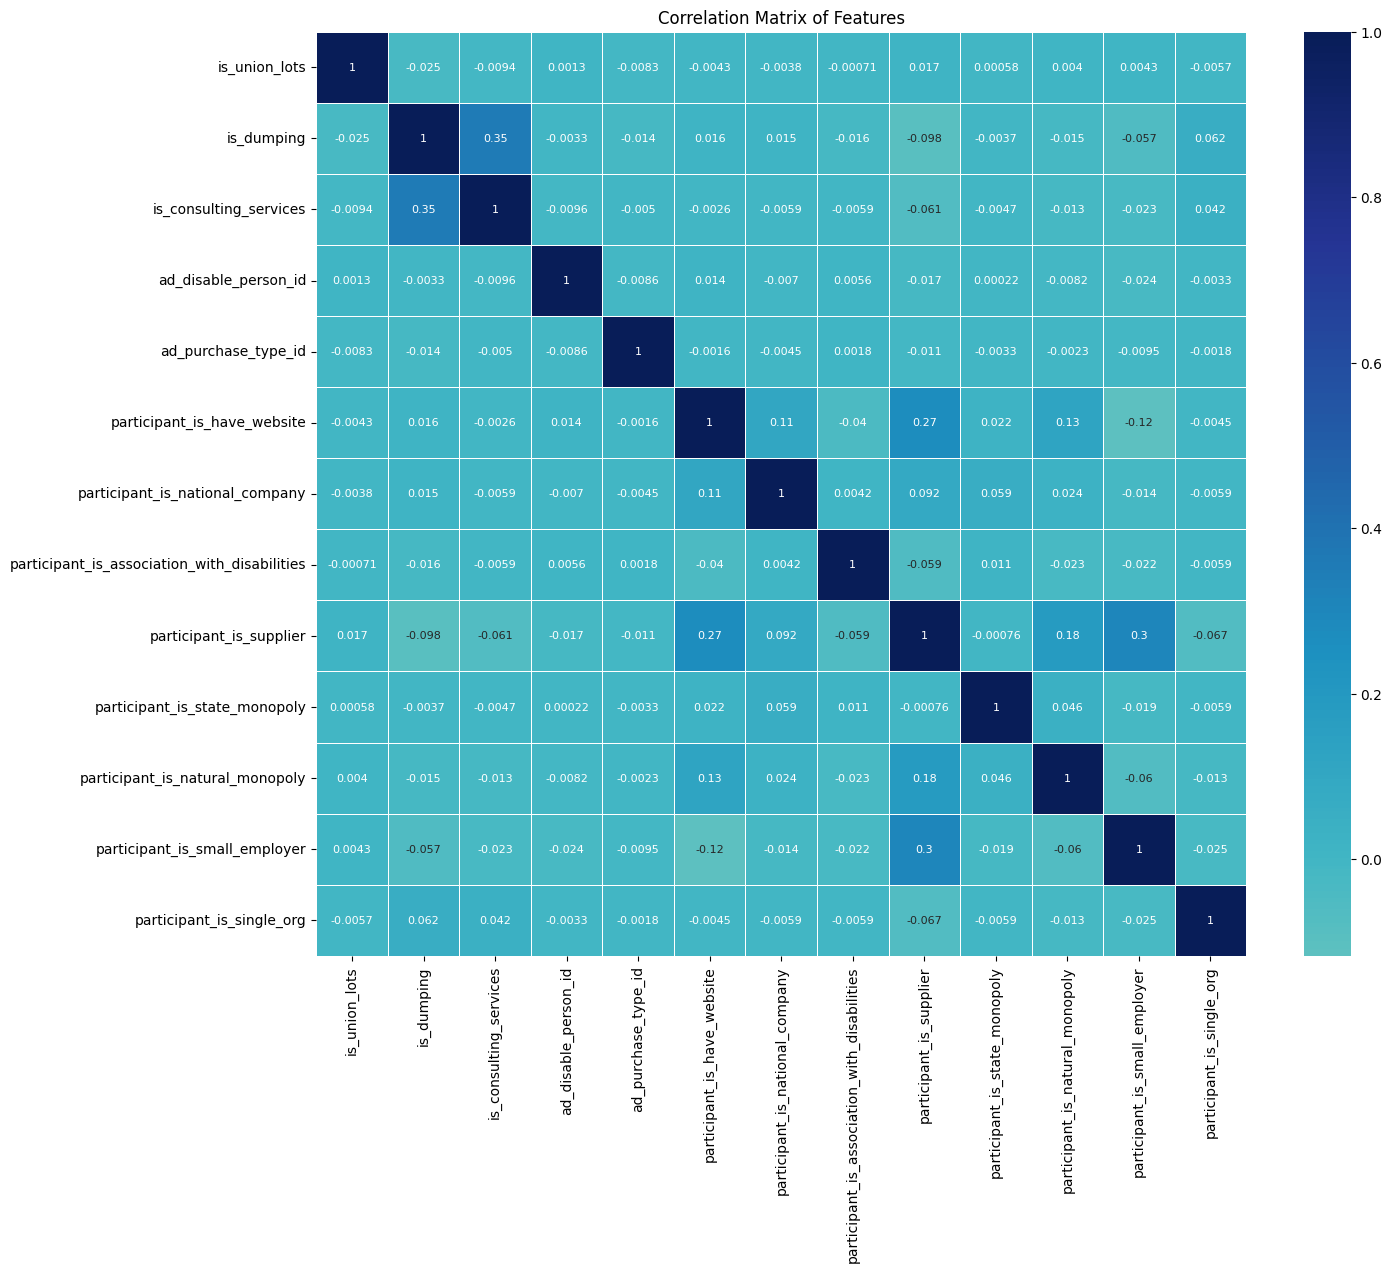

In [25]:
import seaborn as sns
plt.figure(figsize=(15, 12))

sns.heatmap(
    data[group_columns].drop(columns=["participant_is_quazi"]).corr(),
    annot=True, cmap='YlGnBu', center=0, linewidths=0.5, annot_kws={"size": 8}
)

plt.title('Correlation Matrix of Features')
plt.show()

In [26]:
columns_check_correlation = [i for i in group_columns if i not in ["is_disable_person_advertisement", "participant_is_quazi"]]
vif_values = [
    variance_inflation_factor(data[columns_check_correlation].dropna().values, i) 
    for i in range(data[columns_check_correlation].shape[1])
]

for var, vif in zip(columns_check_correlation, vif_values):
    print(f"{var:30s}     {vif:5.2f}")

is_union_lots                       1.01
is_dumping                          1.17
is_consulting_services              1.15
ad_disable_person_id                1.01
ad_purchase_type_id                 1.00
participant_is_have_website         1.49
participant_is_national_company      1.03
participant_is_association_with_disabilities      1.00
participant_is_supplier             1.98
participant_is_state_monopoly       1.04
participant_is_natural_monopoly      1.14
participant_is_small_employer       1.34
participant_is_single_org           1.01


In [27]:
grouped_results_categorical = []

for col in ["plan_trade_method_id", "ad_trade_method_id"]:
    temp_df = (
        data.groupby(col, dropna=False)
        .size()
        .reset_index(name="count")
        .rename(columns={col: 'value'})
    )
    temp_df['name'] = col
    grouped_results_categorical.append(temp_df)

pd.concat(grouped_results_categorical, axis=0, ignore_index=True)[['name', 'value', 'count']]
# лучше дропнуть plan_trade_method_id - NaN много, ad_trade_method_id - хорошая альтернатива, темболее что они идентичны оказались друг другу.

# PlanTradeMethod
# 3 - запрос ценовых предложений
# 2 - Открытый конкурс
# 188 - Конкурс с использованием рейтингово-балльной системы
# 133 - Второй этап конкурса с использованием рамочного соглашения

,name,value,count
0,plan_trade_method_id,124,4291
1,plan_trade_method_id,126,8219
2,plan_trade_method_id,133,10629
3,plan_trade_method_id,177,76
4,plan_trade_method_id,188,14580
5,plan_trade_method_id,2,55030
6,plan_trade_method_id,3,1404695
7,plan_trade_method_id,32,8667
8,plan_trade_method_id,50,2787
9,plan_trade_method_id,52,2583


In [28]:
grouped_results_categorical = []

for col in ["ad_trade_type_id"]:
    temp_df = (
        data.groupby(col, dropna=False)
        .size()
        .reset_index(name="count")
        .rename(columns={col: 'value'})
    )
    temp_df['name'] = col
    grouped_results_categorical.append(temp_df)

pd.concat(grouped_results_categorical, axis=0, ignore_index=True)[['name', 'value', 'count']]

# ad_trade_type_id
# 1 - Первая закупка
# 2 - Повторная закупка
# 10 - Первая закупка
# 11 - Повторная закупка
# 0 - null
# 21 - Первая закупка
# 22 - Повторная закупка
# 24 - Первая закупка
# 25 - Повторная закупка
# 3 - Первая закупка
# 30 - Первая закупка
# 32 - Первая закупка
# 33 - Повторная закупка
# 34 - Первая закупка
# 35 - Повторная закупка
# 39 - Первая закупка
# 4 - Повторная закупка
# 40 - Повторная закупка
# 42 - Первая закупка
# 44 - Повторная закупка с изменениями КД
# 5 - Первая закупка
# 52 - Первая закупка
# 53 - Повторная закупка
# 56 - Первая закупка
# 57 - Повторная закупка
# 6 - Повторная закупка
# 60 - Первая закупка
# 61 - Повторная закупка
# 65 - Первая закупка

,name,value,count
0,ad_trade_type_id,0,16
1,ad_trade_type_id,1,4557042
2,ad_trade_type_id,10,4490
3,ad_trade_type_id,11,146
4,ad_trade_type_id,2,206778
5,ad_trade_type_id,21,6243
6,ad_trade_type_id,22,1828
7,ad_trade_type_id,24,32879
8,ad_trade_type_id,25,4416
9,ad_trade_type_id,3,230953


In [29]:
data['ad_trade_type_id'] = data['ad_trade_type_id'].astype(int)

In [30]:
data = data[data.ad_trade_type_id != 0] # 16 строк, не понятно к чему относятся

In [31]:
repeated_purchase_ids = [2, 11, 22, 25, 33, 35, 4, 40, 44, 53, 57, 6, 61]

# add a new column 'is_repeated_ad' based on the condition
data['is_repeated_ad'] = np.where(data['ad_trade_type_id'].isin(repeated_purchase_ids), 1, 0)

In [32]:
grouped_results_categorical = []

# psd_sign -  Признак работы. 1-работа с ТЭО/ПСД, 2-работа на разработку ТЭО/ПСД. Не соответствует документации
# single_org_sign - не соответствует документации. Закупки Единого организатора КГЗ МФ РК
# is_light_industry - The field wasn’t populated. 
# is_construction_work - Data in this field didn’t match official documentation. Only values 0 and 1 are permissible, other values like 4 were present, which we couldn’t interpret
# 

for col in [
    # "psd_sign",
    # "single_org_sign",
    # "is_light_industry",
    # "is_construction_work",
    "ad_subject_type_id"
]:
    temp_df = (
        data.groupby(col, dropna=False)
        .size()
        .reset_index(name="count")
        .rename(columns={col: 'value'})
    )
    temp_df['name'] = col
    grouped_results_categorical.append(temp_df)

pd.concat(grouped_results_categorical, axis=0, ignore_index=True)[['name', 'value', 'count']]

# ad_subject_type_id
# 1 - Товар, product
# 2 - Работа, work
# 3 - Услуга, service



,name,value,count
0,ad_subject_type_id,1,4031223
1,ad_subject_type_id,2,404998
2,ad_subject_type_id,3,729566


In [33]:
data['ad_subject_type_id'] = data['ad_subject_type_id'].astype(int)

In [34]:
data['is_subject_type_work'] = np.where(data['ad_subject_type_id'] == 2, 1, 0)
data['is_subject_type_service'] = np.where(data['ad_subject_type_id'] == 3, 1, 0)

In [35]:
grouped_results_categorical = []

# ad_single_org_sign - не совсем понятно что за значения 1 2 3
# ad_is_light_industry - мало значений, не соответствует документации
# ad_is_construction_work - не соответствует документации

for col in [
    "ad_single_org_sign",
    "ad_is_light_industry",
    "ad_is_construction_work",
    "participant_creation_date",
    "participant_registration_year",
    "participant_krp_code",
    "participant_kse_code",
]:
    temp_df = (
        data.groupby(col, dropna=False)
        .size()
        .reset_index(name="count")
        .rename(columns={col: 'value'})
    )
    temp_df['name'] = col
    grouped_results_categorical.append(temp_df)

pd.concat(grouped_results_categorical, axis=0, ignore_index=True)[['name', 'value', 'count']]


,name,value,count
0,ad_single_org_sign,0,5038726
1,ad_single_org_sign,1,31787
2,ad_single_org_sign,2,4936
3,ad_single_org_sign,3,90338
4,ad_is_light_industry,0,5131259
5,ad_is_light_industry,1,13940
6,ad_is_light_industry,2,18677
7,ad_is_light_industry,3,1
8,ad_is_light_industry,4,601
9,ad_is_light_industry,5,1076


In [36]:
data['participant_creation_date'] = data['participant_creation_date'].astype(int)
data['participant_registration_year'] = data['participant_registration_year'].astype(int)

In [37]:
data['participant_creation_age'] = 2024 - data['participant_creation_date']
data['participant_registration_age'] = 2024 - data['participant_registration_year']

In [38]:
data['participant_krp_code'] = data['participant_krp_code'].astype(int)

In [39]:
data.participant_oked_list.value_counts().quantile(quantiles)
# , data.participant_oked_list.value_counts()

# pd.DataFrame({
#     'participant_oked_list': data.participant_oked_list.value_counts().index,
#     'count': data.participant_oked_list.value_counts().values,
#     # 'quantile': pd.cut(
#     #     data.participant_oked_list.value_counts().cumsum(),
#     #     bins=[0] + list(data.participant_oked_list.value_counts().cumsum().quantile([0.25, 0.5, 0.75, 1.0])),
#     #     labels=False,
#     #     include_lowest=True
#     # )
# }).head(30)

0.00         1.00
0.01         3.00
0.05         6.85
0.10        50.80
0.25       346.00
0.50     1,236.50
0.75     9,992.25
0.90    59,007.80
0.95    96,222.70
0.99   375,071.19
1.00   691,055.00
Name: count, dtype: float64

In [40]:
for oked in data.participant_oked_list.value_counts().index[data.participant_oked_list.value_counts().values >= data.participant_oked_list.value_counts().quantile(0.9)]:
    column_name = f'is_participant_oked_{oked}'
    data[column_name] = data['participant_oked_list'].apply(lambda x: 1 if x == oked else 0)

In [41]:
data[[f'is_participant_oked_{oked}' for oked in data.participant_oked_list.value_counts().index[data.participant_oked_list.value_counts().values >= data.participant_oked_list.value_counts().quantile(0.9)]]].head()

,is_participant_oked_85310,is_participant_oked_86101,is_participant_oked_85100,is_participant_oked_84120,is_participant_oked_84114,is_participant_oked_84113,is_participant_oked_85322,is_participant_oked_84130,is_participant_oked_85421,is_participant_oked_87200,...,is_participant_oked_84220,is_participant_oked_87300,is_participant_oked_84230,is_participant_oked_91012,is_participant_oked_86210,is_participant_oked_93299,is_participant_oked_85599,is_participant_oked_84112,is_participant_oked_84250,is_participant_oked_85321
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
data.participant_kse_code.value_counts()

participant_kse_code
5    4970167
6     110780
2      78031
7       4721
1       1545
9        196
8        187
4        136
3         24
Name: count, dtype: int64

In [43]:
kse_codes = [5, 6, 2]

for code in kse_codes:
    column_name = f'is_participant_kse_code_{code}'
    data[column_name] = data['participant_kse_code'].apply(lambda x: 1 if x == code else 0)

In [44]:
data['ad_start_date'] = pd.to_datetime(data['ad_start_date'])
data['ad_repeat_start_date'] = pd.to_datetime(data['ad_repeat_start_date'])
data['ad_end_date'] = pd.to_datetime(data['ad_end_date'])
data['ad_repeat_end_date'] = pd.to_datetime(data['ad_repeat_end_date'])

In [45]:
data['f_ad_start_date'] = data['ad_start_date'].combine_first(data['ad_repeat_start_date'])
data['f_ad_end_date'] = data['ad_repeat_end_date'].combine_first(data['ad_end_date'])

In [46]:
data["ad_duration"] = (data['f_ad_end_date'] - data['f_ad_start_date']).dt.days

In [47]:
data = data[~(data.f_ad_end_date < data.f_ad_start_date)] # некорректно заполненные на портале

In [48]:
data["ad_duration"].quantile([0.0, 0.25, 0.5, 0.75, 0.78, 0.8, 0.9, 0.95, 0.99, 0.999, 0.9999, 0.99999, 1.0])

0.00     0.00
0.25     7.00
0.50     7.00
0.75     7.00
0.78     8.00
0.80     8.00
0.90    10.00
0.95    15.00
0.99    33.00
1.00    40.00
1.00    55.00
1.00    89.34
1.00   886.00
Name: ad_duration, dtype: float64

In [48]:
# data[data.ad_duration > 90]

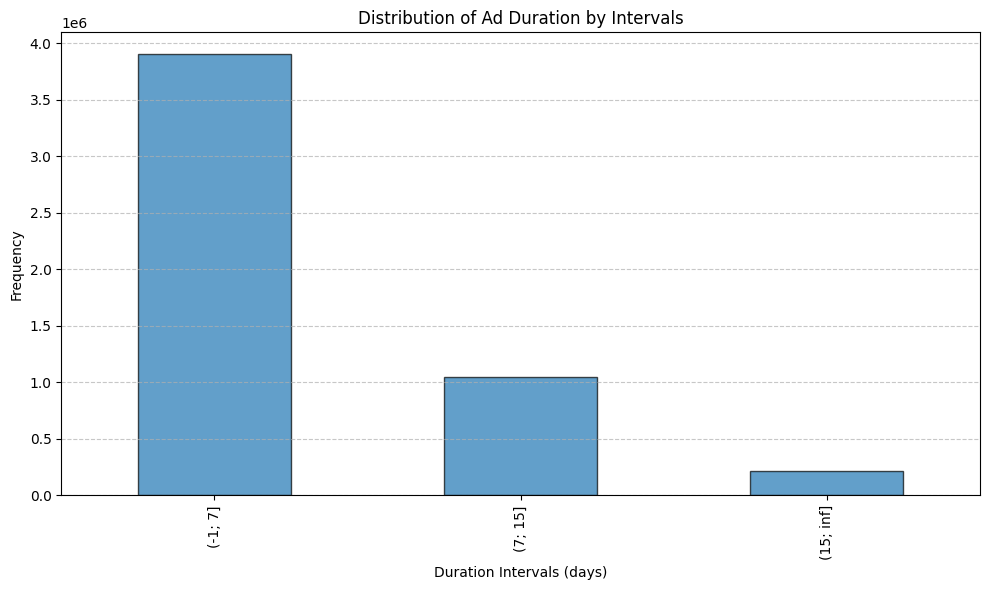

In [49]:
bins = [-1, 7, 15, float('inf')]
labels = ['(-1; 7]', '(7; 15]', '(15; inf]']

plt.figure(figsize=(10, 6))
pd.cut(data['ad_duration'], bins=bins, labels=labels, include_lowest=True).value_counts(sort=False).plot(kind='bar', edgecolor='black', alpha=0.7)
plt.title("Distribution of Ad Duration by Intervals")
plt.xlabel("Duration Intervals (days)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [50]:
data['ad_duration_power'] = pd.cut(
    data['ad_duration'],
    bins=[-1, 7, 15, float('inf')],
    labels=[0, 1, 2]
).astype(int)

In [51]:
data['is_multi_year'] = (data.ad_fin_years.apply(lambda x: x.split(":")).apply(lambda x: len(x)) > 1).astype(int)

In [ ]:
        # "ad_katos",
        # "participant_kato_list",
        # "participant_kopf_code",
        # "participant_branches",
        # "participant_parent_company",

In [52]:
data.participant_kopf_code.value_counts()

participant_kopf_code
ГУ     2729901
ГП     1801383
АО      308981
ТОО     169983
УЧР        600
Name: count, dtype: int64

In [53]:
data = pd.concat(
    [
        data,
        pd.get_dummies(data['participant_kopf_code'], prefix='is_participant_kopf').astype(int).drop(columns=['is_participant_kopf_УЧР'])
    ],
    axis=1
)

In [54]:
data['has_participant_branches'] = data['participant_branches'].apply(
    lambda x: [] if pd.isna(x) else x.split(":")
).apply(lambda x: len(x) > 0).astype(int)

In [55]:
data["has_participant_parent_company"] = data['participant_parent_company'].apply(
    lambda x: [] if pd.isna(x) else x.split(":")
).apply(lambda x: len(x) > 0).astype(int)

In [ ]:
####################################################################################################################################################################
# Start Training Model

In [633]:
def overprice_watchdog(y_true, y_pred):
    alpha = 0.0

    residual = y_pred - y_true
    gradient = np.where(residual > 0, 2 * alpha * residual, 2 * (1 - alpha) * residual)
    hessian = 2 * np.ones_like(residual)

    return gradient, hessian
    # residual = y_pred - y_true
    # grad = 2 * residual
    # hess = 2 * np.ones_like(residual)

    # grad[residual > 0] *= 1.5
    # return grad, hess


In [56]:
np.log2(data["sw_total_price_wdiscount"].quantile(quantiles))

0.00   10.50
0.01   11.07
0.05   11.97
0.10   12.71
0.25   14.11
0.50   15.94
0.75   18.07
0.90   20.33
0.95   21.84
0.99   24.84
1.00   35.51
Name: sw_total_price_wdiscount, dtype: float64

In [58]:
columns_to_take = [
    "total_amount",
    # "has_participant_branches",
    # "is_multi_year",
    # "has_participant_parent_company",
    "ad_duration_power",
    # # "is_participant_kopf_ГУ",
    # "is_participant_kopf_ГП",
    # # "is_participant_kopf_АО",
    # "is_participant_kopf_ТОО",
    # # "is_participant_kse_code_2",
    # # "is_participant_kse_code_5",
    # # "is_participant_kse_code_6",
    # "participant_krp_code",
    # "participant_registration_age",
    # "participant_creation_age",
    
    "is_subject_type_work",
    "is_subject_type_service",
    # "total_count"
] 
# + list(data.filter(like="is_participant_oked_").columns)

X = data[np.log2(data["sw_total_price_wdiscount"]) <= 24.84][columns_to_take].copy()
X['total_amount'] = np.log2(X['total_amount'] + 1)


y = data[np.log2(data["sw_total_price_wdiscount"]) <= 24.84]["sw_total_price_wdiscount"] - 1
y = np.log2(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

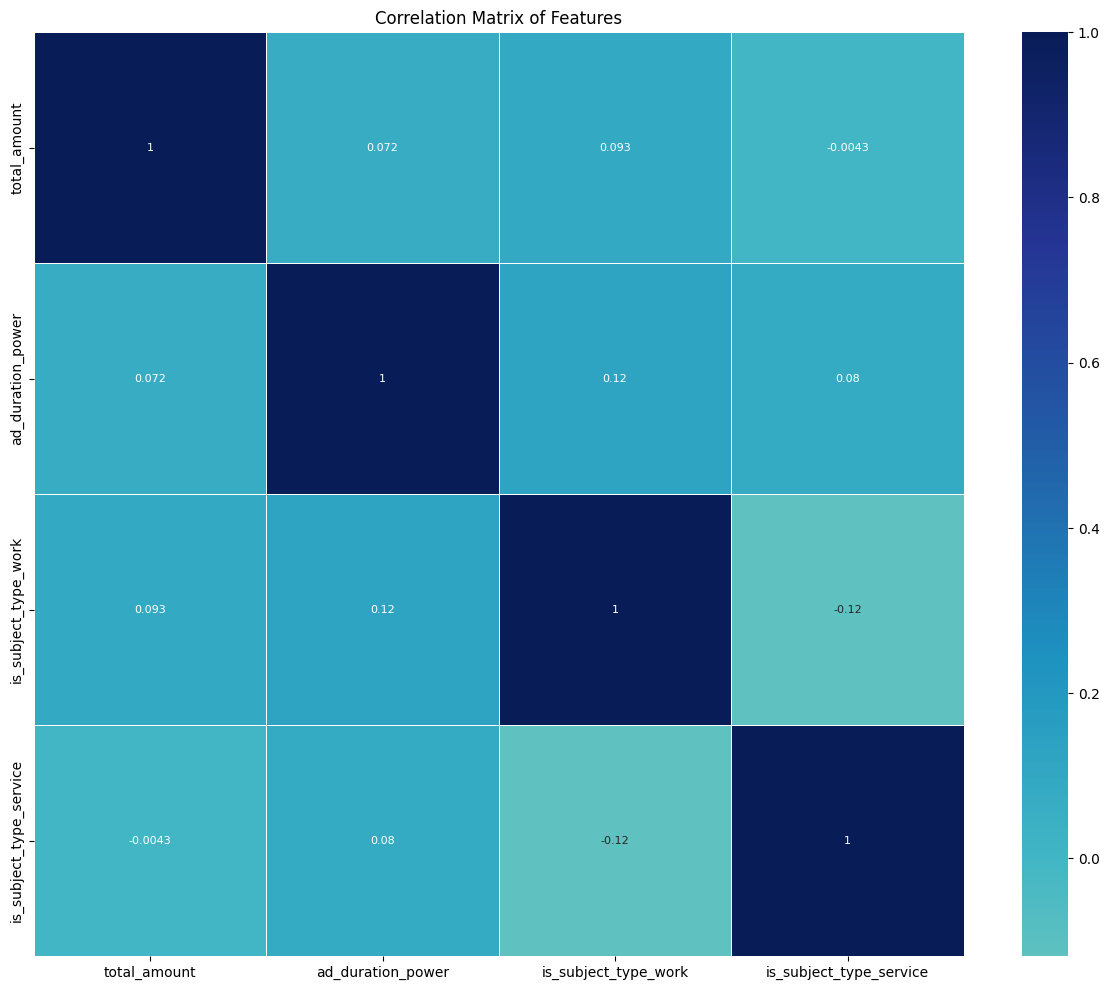

In [57]:
plt.figure(figsize=(15, 12))

sns.heatmap(
    data[columns_to_take].corr(),
    annot=True, cmap='YlGnBu', center=0, linewidths=0.5, annot_kws={"size": 8}
)

plt.title('Correlation Matrix of Features')
plt.show()

In [62]:
import statsmodels.api as sm

X_train_with_intercept = sm.add_constant(X_train)

# Fit the regression model using statsmodels
model = sm.OLS(y_train, X_train_with_intercept).fit()

# Get the summary table
summary_df = pd.DataFrame({
    "Feature": ["Intercept"] + list(X_train.columns),
    "Coefficient": model.params.values,
    "P-Value": model.pvalues.values,
    "Standard Error": model.bse.values
})

# Add Absolute Contribution column for interpretability
summary_df["Absolute Contribution"] = abs(summary_df["Coefficient"])

# Sort by absolute contribution
summary_df = summary_df.sort_values(by="Absolute Contribution", ascending=False).reset_index(drop=True)


y_pred = model.predict(sm.add_constant(X_test))

mse = mean_squared_error(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)
r2 = r2_score(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)

summary_df


# linreg = LinearRegression()
# linreg.fit(X_train, y_train)

# # Predict on the test set
# y_pred = linreg.predict(X_test)

# # Evaluate performance
# mse = mean_squared_error(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)
# r2 = r2_score(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)

# mse, r2, np.sqrt(mse), mean_absolute_error(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)

,Feature,Coefficient,P-Value,Standard Error,Absolute Contribution
0,total_amount,0.98,0.00,0.00,0.98
1,Intercept,-0.06,0.00,0.00,0.06
2,ad_duration_power,0.06,0.00,0.00,0.06
3,is_subject_type_work,0.02,0.00,0.00,0.02
4,is_subject_type_service,-0.02,0.00,0.00,0.02


In [921]:
import pickle

In [922]:
with open("linear_regression_model_v1.pkl", "wb") as file:
    pickle.dump(model, file)

In [930]:
mse, r2, np.sqrt(mse), mean_absolute_error(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)

(294864800382.4598,
 0.9464858865641749,
 np.float64(543014.5489602095),
 128170.42602990188)

In [929]:
# MSE: 5033015827510304.0, R2 Score: 0.4112988377639333; test-rmse:0.40979	test-custom_rmse:0.40979
(y_pred > y_test).sum(), ((y_pred > y_test).sum() / len(y_test)) * 100

(np.int64(397674), np.float64(38.87969871885119))

In [ ]:
####################################################################################################################################################################

[0]	train-rmse:15.15018	train-custom_rmse:15.15018	test-rmse:15.15042	test-custom_rmse:15.15042
[1]	train-rmse:14.39312	train-custom_rmse:14.39312	test-rmse:14.39334	test-custom_rmse:14.39334
[2]	train-rmse:13.67394	train-custom_rmse:13.67394	test-rmse:13.67413	test-custom_rmse:13.67413
[3]	train-rmse:12.99075	train-custom_rmse:12.99075	test-rmse:12.99091	test-custom_rmse:12.99091
[4]	train-rmse:12.34173	train-custom_rmse:12.34173	test-rmse:12.34187	test-custom_rmse:12.34187
[5]	train-rmse:11.72520	train-custom_rmse:11.72520	test-rmse:11.72532	test-custom_rmse:11.72532
[6]	train-rmse:11.13952	train-custom_rmse:11.13952	test-rmse:11.13961	test-custom_rmse:11.13961
[7]	train-rmse:10.58315	train-custom_rmse:10.58315	test-rmse:10.58322	test-custom_rmse:10.58322
[8]	train-rmse:10.05463	train-custom_rmse:10.05463	test-rmse:10.05468	test-custom_rmse:10.05468
[9]	train-rmse:9.55257	train-custom_rmse:9.55257	test-rmse:9.55260	test-custom_rmse:9.55260
[10]	train-rmse:9.07565	train-custom_rmse:9.

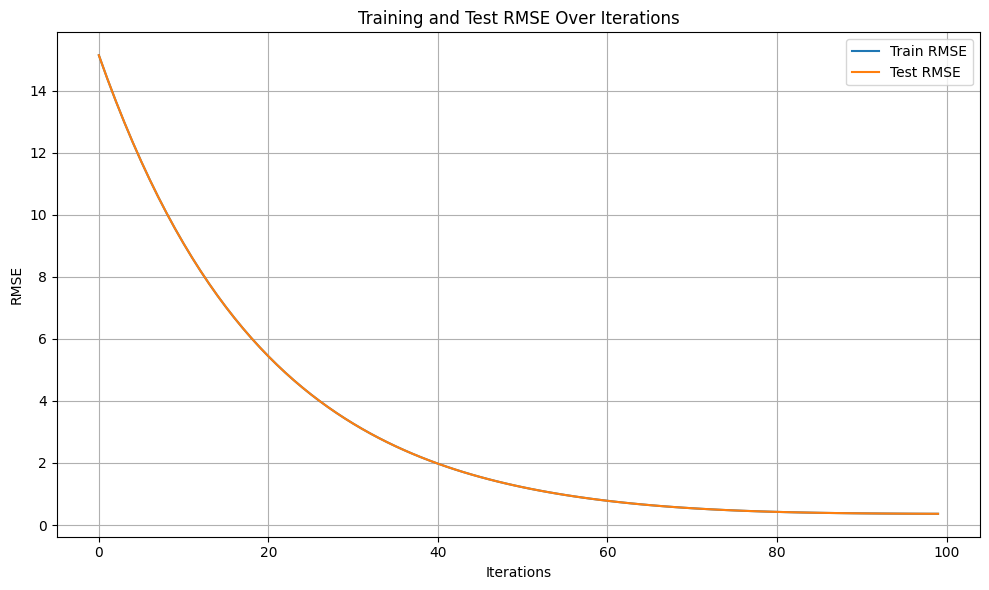

In [59]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


def overprice_watchdog(y_pred, dtrain):
    y_true = dtrain.get_label()
    residual = y_pred - y_true

    alpha = 0.4
    gradient = np.where(residual > 0, 2 * alpha * residual, 2 * (1 - alpha) * residual)
    hessian = np.where(residual > 0, 2 * alpha, 2 * (1 - alpha))
    # hessian = 2 * np.ones_like(residual)

    return gradient, hessian


def custom_rmse(y_pred, dtrain):
    y_true = dtrain.get_label()
    # y_pred = np.power(2, y_pred) + 1
    # y_true = np.power(2, y_true) + 1
    
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    return "custom_rmse", rmse


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
evals_result = {}


params = {
    "learning_rate": 0.05,
    "max_depth": 7,
    "random_state": 42,
    # "reg_alpha": 1
    # "n_estimators": 100
}

evals = [(dtrain, "train"), (dtest, "test")]
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    obj=overprice_watchdog,
    custom_metric=custom_rmse,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=True
)

y_pred = model.predict(dtest)

mse = mean_squared_error(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)
r2 = r2_score(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)
print(f"MSE: {mse}, R2 Score: {r2}")


plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['custom_rmse'], label='Train RMSE')
plt.plot(evals_result['test']['custom_rmse'], label='Test RMSE',)
plt.title("Training and Test RMSE Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [60]:
# (np.int64(358119), np.float64(35.012494720540616), 123810.45023454943)
(y_pred > y_test).sum(), ((y_pred > y_test).sum() / len(y_test)) * 100, mean_absolute_error(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)

(np.int64(359708), np.float64(35.16746949434078), 121839.8256571717)

In [124]:
model.save_model("xgb_model_v2.json")

In [61]:
xgb_summary = data.loc[y_test.index]
xgb_summary["base_prediction"] = np.power(2, y_pred) + 1
xgb_summary = xgb_summary[["fw_total_price_wdiscount", "base_prediction", "sw_total_price_wdiscount", "total_amount"]]
xgb_summary['after_prediction_unearned_revenue'] = xgb_summary.apply(
    lambda row: min(row['sw_total_price_wdiscount'], row['sw_total_price_wdiscount'] - row['base_prediction'])
    if row['base_prediction'] > row['sw_total_price_wdiscount'] else row['sw_total_price_wdiscount'] - row['base_prediction'],
    axis=1
)

# xgb_summary['after_prediction_unearned_revenue'] = xgb_summary['sw_total_price_wdiscount'] - xgb_summary['base_prediction']

quantile_values = xgb_summary['total_amount'].quantile(quantiles)
cumulative_lots = [xgb_summary['total_amount'].le(value).sum() for value in quantile_values]
lots_in_quantile = np.diff([0] + cumulative_lots)

xgb_summary['unearned_revenue'] = xgb_summary['sw_total_price_wdiscount'] - xgb_summary['fw_total_price_wdiscount']
xgb_summary['unearned_revenue_pct'] = (xgb_summary['sw_total_price_wdiscount'] / xgb_summary['fw_total_price_wdiscount'] - 1) * 100

range_start = [0] + list(quantile_values)[:-1]
range_end = list(quantile_values)

# total unearned revenue within each quantile range
unearned_revenue = []
cumulative_unearned_revenue = []
non_cumulative_unearned_revenue_pct = []
cumulative_sum = 0
after_predictions_unearned_revenue = []

for start, end in zip(range_start, range_end):
    unearned_sum = xgb_summary[(xgb_summary['total_amount'] > start) & (xgb_summary['total_amount'] <= end)]['unearned_revenue'].sum()
    unearned_revenue.append(unearned_sum)

    cumulative_sum += unearned_sum
    cumulative_unearned_revenue.append(cumulative_sum)

    avg_pct = xgb_summary[(xgb_summary['total_amount'] > start) & (xgb_summary['total_amount'] <= end)]['unearned_revenue_pct'].quantile(0.667) if not xgb_summary[(xgb_summary['total_amount'] > start) & (xgb_summary['total_amount'] <= end)].empty else 0
    non_cumulative_unearned_revenue_pct.append(avg_pct)
    
    after_predictions_sum = xgb_summary[(xgb_summary['total_amount'] > start) & (xgb_summary['total_amount'] <= end)]['after_prediction_unearned_revenue'].sum()
    after_predictions_unearned_revenue.append(after_predictions_sum)

    
unearned_revenue_summary = pd.DataFrame({
    "Quantile": quantiles,
    "LotQuantileBound": quantile_values,
    "CumulativeLotsCount": cumulative_lots,
    "LotsInQuantile": lots_in_quantile,
    "UnearnedRevenue": unearned_revenue,
    "CumulativeUnearnedRevenue": cumulative_unearned_revenue,
    "NonCumulativeUnearnedRevenueQ66percent": non_cumulative_unearned_revenue_pct,
    "AfterPredictionUnearnedRevenue": after_predictions_unearned_revenue
})
unearned_revenue_summary["UnearnedRevenueRatioDecrease"] = (1 - unearned_revenue_summary["AfterPredictionUnearnedRevenue"] / unearned_revenue_summary["CumulativeUnearnedRevenue"]) * 100

unearned_revenue_summary

,Quantile,LotQuantileBound,CumulativeLotsCount,LotsInQuantile,UnearnedRevenue,CumulativeUnearnedRevenue,NonCumulativeUnearnedRevenueQ66percent,AfterPredictionUnearnedRevenue,UnearnedRevenueRatioDecrease
0.00,0.00,"1,450.00",1,1,0.00,0.00,0.00,-205.52,inf
0.01,0.01,"2,464.27",10229,10228,"1,649,311.50","1,649,311.50",10.78,"732,471.69",55.59
0.05,0.05,"4,830.00",51144,40915,"16,267,415.27","17,916,726.77",16.85,"5,093,521.61",71.57
0.10,0.10,"8,000.00",105453,54309,"38,429,206.10","56,345,932.87",17.50,"12,684,444.94",77.49
0.25,0.25,"22,000.00",256277,150824,"218,002,475.81","274,348,408.68",16.21,"90,714,690.22",66.93
0.50,0.50,"80,357.14",511690,255413,"1,004,520,588.52","1,278,868,997.20",13.88,"528,692,188.15",58.66
0.75,0.75,"337,500.00",767133,255443,"3,363,265,346.03","4,642,134,343.23",11.98,"2,335,352,883.89",49.69
0.90,0.90,"1,492,081.84",920558,153425,"7,302,512,036.32","11,944,646,379.55",10.68,"6,455,475,050.48",45.96
0.95,0.95,"3,717,051.07",971700,51142,"7,204,742,530.50","19,149,388,910.05",9.11,"7,737,041,978.00",59.60
0.99,0.99,"15,460,334.11",1012614,40914,"16,160,996,364.48","35,310,385,274.53",7.99,"20,300,268,455.35",42.51


In [64]:
for i in np.arange(0.01, 1.01, 0.01):
    ((y_pred * i > y_test).sum() / len(y_test)) * 100


_results = []

# Iterate through multipliers and compute the percentage of over-predictions
for i in np.arange(0.01, 1.01, 0.01):
    over_prediction_percentage = (y_pred * i > y_test).sum() / len(y_test) * 100
    _results.append({"multiplier": i, "over_prediction_percent": over_prediction_percentage})

pd.DataFrame(_results).sort_values(by="over_prediction_percent", ascending=False).head(12)

,multiplier,over_prediction_percent
99,1.00,35.17
98,0.99,23.99
97,0.98,16.04
96,0.97,10.27
95,0.96,5.92
94,0.95,3.06
93,0.94,1.37
92,0.93,0.51
91,0.92,0.16
90,0.91,0.05


In [ ]:
# data.loc[X_test.index]

# data['fw_total_price_wdiscount'].loc[X_test.index]


In [107]:
# def choose_best_arm(predictions, true_value):
def choose_best_arm(predictions, fw_price, sw_price, total_amount):
    """
        Select the best arm based on predictions being:
        1. Closest to sw_price.
        2. Within the range [fw_price, sw_price].
        3. Not deviating excessively from total_amount.
    """

    # Step 1: Filter predictions within [fw_price, sw_price]
    valid_predictions = [pred for pred in predictions if fw_price < pred < sw_price]

    # Step 2: Among valid predictions, prefer the one closest to sw_price
    if valid_predictions:
        closest_prediction = max(valid_predictions)  # Closest to sw_price
    else:
        # Fallback: Choose prediction closest to sw_price but <= sw_price
        fallback_predictions = [pred for pred in predictions if pred < sw_price]
        if fallback_predictions:
            closest_prediction = max(fallback_predictions)
        else:
            # Last resort: Choose prediction closest to total_amount
            closest_prediction = min(predictions, key=lambda x: abs(x - total_amount))

    # index of the chosen prediction
    return predictions.index(closest_prediction)
    
    # valid_predictions = [pred for pred in predictions if pred <= true_value]

    # if valid_predictions:
    #     # Find the closest valid prediction to the true_value
    #     closest_prediction = max(valid_predictions)  # Closest lower value
    # else:
    #     # If no predictions are valid, pick the lowest prediction
    #     closest_prediction = min(predictions)

    # # Return the index of the closest prediction
    # return predictions.index(closest_prediction)

# Number of pricing strategies
#pricing_strategies = [0.90, 0.95, 1.0, 1.05]
pricing_strategies = [0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]
n_arms = len(pricing_strategies)
successes = [0] * n_arms
failures = [0] * n_arms

results = []

fw_prices = data['fw_total_price_wdiscount'].loc[X_test.index]
sw_prices = data['sw_total_price_wdiscount'].loc[X_test.index]
initial_lot_prices = data['total_amount'].loc[X_test.index]

for i in range(len(X_test)):
    if i % 10 == 0:
        print(i)
    if i == 200_000:
        break

    single_row = X_test.iloc[i:i + 1]
    dmatrix_input = xgb.DMatrix(single_row)

    base_prediction = np.power(2, model.predict(dmatrix_input)[0]) + 1

    # Adjust predictions using all strategies
    adjusted_predictions = [base_prediction * multiplier for multiplier in pricing_strategies]

    fw_price = fw_prices.iloc[i]
    sw_price = sw_prices.iloc[i]
    total_amount = X_test.iloc[i]["total_amount"] 

    # True value for comparison
    # true_value = y_test.iloc[i]

    # Choose the best arm
    
    # chosen_arm = choose_best_arm(adjusted_predictions, true_value)
    chosen_arm = choose_best_arm(adjusted_predictions, fw_price, sw_price, total_amount)


    # Final adjusted prediction using the chosen arm
    adjusted_prediction = adjusted_predictions[chosen_arm]

    reward = 1 if fw_price < adjusted_prediction < sw_price else 0
    
    # Determine if the chosen prediction is rewarded
    # reward = 1 if adjusted_prediction <= true_value else 0

    if reward:
        successes[chosen_arm] += adjusted_prediction / sw_price
    else:
        failures[chosen_arm] += 1

    results.append({
        # "true_value": true_value,
        "first_winner_price": fw_price,
        "base_prediction": base_prediction,
        "adjusted_prediction": adjusted_prediction,
        "second_winner_price": sw_price,
        "initial_lot_price": initial_lot_prices.iloc[i],
        "chosen_arm": chosen_arm,
        "reward": reward
    })

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)
results_df.head()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

,first_winner_price,base_prediction,adjusted_prediction,second_winner_price,initial_lot_price,chosen_arm,reward
0,"19,620.00","16,962.27","16,962.27","20,700.00","21,500.00",6,0
1,"170,822.40","127,642.22","127,642.22","173,328.00","174,108.00",6,0
2,"22,396.00","18,375.19","18,375.19","23,000.00","23,000.00",6,0
3,"2,437,000.00","2,107,013.25","2,107,013.25","2,700,000.00","3,211,688.00",6,0
4,"135,940.00","115,875.43","115,875.43","145,500.00","150,000.00",6,0


In [112]:
# len(results_df[results_df.base_prediction > results_df.second_winner_price]), len(results_df[results_df.adjusted_prediction > results_df.second_winner_price])

mean_absolute_error(results_df.second_winner_price.values - 1, results_df.adjusted_prediction.values) 

112419.84892466516

In [109]:
(results_df.second_winner_price.values > results_df.adjusted_prediction.values).sum() / len(results_df)

np.float64(0.716605)

In [113]:
def thompson_sampling_bandit(n_arms, successes, failures):
    sampled_values = [np.random.beta(successes[i] + 1, failures[i] + 1) for i in range(n_arms)]
    return np.argmax(sampled_values)

thompson_sampling_bandit(len(pricing_strategies), successes, failures), successes, failures
# choose_best_arm([168_651.94])

(np.int64(1),
 [np.float64(1979.8184866891775),
  np.float64(1908.261819632896),
  np.float64(2119.9299452984737),
  np.float64(2074.3453225191824),
  np.float64(2177.133351210614),
  np.float64(2120.759620531656),
  np.float64(34695.66953559128)],
 [56831, 129, 160, 171, 199, 169, 90929])

In [110]:
# xgb_summary = data.loc[y_test.index]
# xgb_summary["base_prediction"] = np.power(2, y_pred) + 1
# xgb_summary = xgb_summary[["fw_total_price_wdiscount", "base_prediction", "sw_total_price_wdiscount", "total_amount"]]
# xgb_summary['after_prediction_unearned_revenue'] = xgb_summary.apply(
#     lambda row: min(row['sw_total_price_wdiscount'], row['sw_total_price_wdiscount'] - row['base_prediction'])
#     if row['base_prediction'] > row['sw_total_price_wdiscount'] else row['sw_total_price_wdiscount'] - row['base_prediction'],
#     axis=1
# )

results_df['after_prediction_unearned_revenue'] = results_df.apply(
    lambda row: min(row['second_winner_price'], row['second_winner_price'] - row['adjusted_prediction'])
    if row['adjusted_prediction'] > row['second_winner_price'] else row['second_winner_price'] - row['adjusted_prediction'],
    axis=1
)

quantile_values = results_df['initial_lot_price'].quantile(quantiles)
cumulative_lots = [results_df['initial_lot_price'].le(value).sum() for value in quantile_values]
lots_in_quantile = np.diff([0] + cumulative_lots)

results_df['unearned_revenue'] = results_df['second_winner_price'] - results_df['first_winner_price']
results_df['unearned_revenue_pct'] = (results_df['second_winner_price'] / results_df['first_winner_price'] - 1) * 100

range_start = [0] + list(quantile_values)[:-1]
range_end = list(quantile_values)

# total unearned revenue within each quantile range
unearned_revenue = []
cumulative_unearned_revenue = []
non_cumulative_unearned_revenue_pct = []
cumulative_sum = 0
after_predictions_unearned_revenue = []

for start, end in zip(range_start, range_end):
    unearned_sum = results_df[(results_df['initial_lot_price'] > start) & (results_df['initial_lot_price'] <= end)]['unearned_revenue'].sum()
    unearned_revenue.append(unearned_sum)

    cumulative_sum += unearned_sum
    cumulative_unearned_revenue.append(cumulative_sum)

    avg_pct = results_df[(results_df['initial_lot_price'] > start) & (results_df['initial_lot_price'] <= end)]['unearned_revenue_pct'].quantile(0.667) if not results_df[(results_df['initial_lot_price'] > start) & (results_df['initial_lot_price'] <= end)].empty else 0
    non_cumulative_unearned_revenue_pct.append(avg_pct)
    
    after_predictions_sum = results_df[(results_df['initial_lot_price'] > start) & (results_df['initial_lot_price'] <= end)]['after_prediction_unearned_revenue'].sum()
    after_predictions_unearned_revenue.append(after_predictions_sum)

    
unearned_revenue_summary = pd.DataFrame({
    "Quantile": quantiles,
    "LotQuantileBound": quantile_values,
    "CumulativeLotsCount": cumulative_lots,
    "LotsInQuantile": lots_in_quantile,
    "UnearnedRevenue": unearned_revenue,
    "CumulativeUnearnedRevenue": cumulative_unearned_revenue,
    "NonCumulativeUnearnedRevenueQ66percent": non_cumulative_unearned_revenue_pct,
    "AfterPredictionUnearnedRevenue": after_predictions_unearned_revenue
})
unearned_revenue_summary["UnearnedRevenueRatioDecrease"] = (1 - unearned_revenue_summary["AfterPredictionUnearnedRevenue"] / unearned_revenue_summary["CumulativeUnearnedRevenue"]) * 100

unearned_revenue_summary

,Quantile,LotQuantileBound,CumulativeLotsCount,LotsInQuantile,UnearnedRevenue,CumulativeUnearnedRevenue,NonCumulativeUnearnedRevenueQ66percent,AfterPredictionUnearnedRevenue,UnearnedRevenueRatioDecrease
0.00,0.00,"1,473.30",1,1,3.30,3.30,0.22,-78.19,"2,469.49"
0.01,0.01,"2,485.71",2000,1999,"315,836.26","315,839.56",10.60,"194,710.91",38.35
0.05,0.05,"4,910.70",10006,8006,"3,131,308.43","3,447,147.99",16.42,"1,427,855.86",58.58
0.10,0.10,"8,000.00",20600,10594,"7,617,158.26","11,064,306.25",18.10,"3,362,993.29",69.61
0.25,0.25,"22,000.00",50204,29604,"43,078,076.67","54,142,382.92",16.28,"24,442,704.20",54.85
0.50,0.50,"80,357.10",100043,49839,"195,633,012.09","249,775,395.01",13.85,"136,974,744.31",45.16
0.75,0.75,"339,285.00",150001,49958,"659,078,377.52","908,853,772.53",12.00,"595,531,091.51",34.47
0.90,0.90,"1,500,000.00",180296,30295,"1,469,097,295.18","2,377,951,067.71",10.73,"1,574,764,551.07",33.78
0.95,0.95,"3,739,057.60",190000,9704,"1,366,109,114.44","3,744,060,182.15",9.09,"1,816,104,229.49",51.49
0.99,0.99,"15,400,017.86",198000,8000,"3,126,817,944.48","6,870,878,126.63",7.70,"4,657,810,297.87",32.21


In [111]:
# (results_df.adjusted_prediction > results_df.true_value).sum()

# # (y_pred > y_test).sum(), ((y_pred > y_test).sum() / len(y_test)) * 100, mean_absolute_error(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)

In [945]:
# def thompson_sampling_bandit(n_arms, successes, failures):
#     sampled_values = [np.random.beta(successes[i] + 1, failures[i] + 1) for i in range(n_arms)]
#     return np.argmax(sampled_values)

# # Initialize Bandit Parameters
# n_arms = 3  # Number of pricing strategies
# successes = [0] * n_arms
# failures = [0] * n_arms
# pricing_strategies = [0.9, 1.0, 1.1]

# # Simulate predictions and rewards
# results = []
# for i in range(len(X_test)):
    # if i % 10 == 0:
    #     print(i)
    # if i == 100_000:
    #     break
#     single_row = X_test.iloc[i:i + 1]
#     dmatrix_input = xgb.DMatrix(single_row)
#     base_prediction = model.predict(dmatrix_input)[0]

#     # Select the best arm using Thompson Sampling
#     chosen_arm = thompson_sampling_bandit(n_arms, successes, failures)

#     # Adjust prediction using chosen arm
#     adjusted_prediction = base_prediction * pricing_strategies[chosen_arm]

#     # Simulate reward (e.g., profit, user feedback)
#     true_value = y_test.iloc[i]  # True value for comparison
#     reward = 1 if adjusted_prediction <= true_value else 0  # Example reward logic

#     # Update successes or failures for the chosen arm
#     if reward:
#         successes[chosen_arm] += 1
#     else:
#         failures[chosen_arm] += 1

#     # Log results
#     results.append({
#         "true_value": true_value,
#         "base_prediction": base_prediction,
#         "adjusted_prediction": adjusted_prediction,
#         "chosen_arm": chosen_arm,
#         "reward": reward
#     })

# # Analyze Bandit Results
# print("Successes:", successes)
# print("Failures:", failures)
# results_df = pd.DataFrame(results)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [955]:
# results_df

thompson_sampling_bandit(n_arms, successes, failures), successes, failures

(np.int64(0), [99978, 0, 0], [20, 1, 1])

In [ ]:

def custom_mape(y_pred, dtrain):
    y_true = dtrain.get_label()
    
    # Reverse the log2 transformation for both y_pred and y_true
    y_pred_original = np.power(2, y_pred) + 1
    y_true_original = np.power(2, y_true) + 1

    # Calculate MAPE
    mape = np.mean(np.abs((y_true_original - y_pred_original) / y_true_original)) * 100
    
    return "custom_mape", mape


In [268]:
# data.groupby('is_union_lots').size().reset_index(name="count")

# # data[
# #     [
# #         "total_count",
# #         "total_amount",
# #         "ad_lots_count"
# #     ]
# # ].corr()
# import seaborn as sns

# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='total_count', y='total_amount', data=data, alpha=0.5)
# plt.title('Relationship Between total_count and Target Variable')
# plt.xlabel('total_count')
# plt.ylabel('Target Variable')
# plt.show()


# #         # "total_count",        
# #         # "ad_lots_count",
# # # data[data.total_count > data.total_count.quantile(0.99)]
# # # data.total_count.quantile(quantiles)

# # plt.figure(figsize=(10, 6))
# # plt.hist(np.log1p(data[data.total_count <= data.total_count.quantile(0.99)]['total_count']+1), bins=100, edgecolor='black', alpha=0.7)
# # plt.title('Distribution of total_count')
# # plt.xlabel('Total Count')
# # plt.ylabel('Frequency')
# # plt.grid(axis='y', linestyle='--', alpha=0.7)
# # plt.show()

,is_union_lots,count
0,0,5087738
1,1,82415


In [451]:
# data.participant_kse_code.value_counts()

In [450]:
# data[data.fw_total_price_wdiscount == data.total_amount].participant_kse_code.value_counts()

In [452]:
# data[data.fw_total_price_wdiscount == data.total_amount].ad_subject_type_id.value_counts(), data.ad_subject_type_id.value_counts()

In [454]:
# (data['total_amount'] / data['fw_total_price_wdiscount']).quantile(quantiles)

In [427]:
# data[data.unearned_revenue_pct > 4000]
# # unearned_revenue_pct

In [68]:
# data.sw_total_price_wdiscount - data.fw_total_price_wdiscount

In [343]:
X = data[
    [
        "total_amount"
    ]
].rename(
    columns={
        "total_amount": "initial_lot_price",
    }
)
# .reset_index(drop=True)

y = data["sw_total_price_wdiscount"]

X["initial_lot_price"] = np.log2(X["initial_lot_price"] + 1)
# X["advertisement_total_price"] = np.log2(X["advertisement_total_price"] + 1)
y = np.log2(y + 1)



In [107]:
# data['participant_is_small_employer'].value_counts() # возможно стоит исключить те у кого ad_fin_years == '0'

In [346]:
# xgb_model = xgb.XGBRegressor(
#     # learning_rate=0.1,
#     # max_depth=7,
#     # objective='reg:squarederror',
#     # random_state=42,
#     learning_rate=0.05,
#     max_depth=3,
#     n_estimators=100,
#     reg_lambda=1.0,  # L2 regularization
#     reg_alpha=0.5,   # L1 regularization
#     random_state=42
# )
# xgb_model.fit(X_train, y_train)

xgb_model = LinearRegression()
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2, np.sqrt(mse), mean_absolute_error(y_test, y_pred)

# (0.01799905104726207,
 # 0.979990650697431,
 # np.float64(0.13416054206532588),
 # 0.09223476723484725)

(0.18712031638672544,
 0.9811494578645338,
 np.float64(0.4325740588462575),
 0.30532992669210124)

In [347]:
y_pred_actual = (2 ** y_pred) - 1
y_test_actual = (2 ** y_test) - 1

mae_actual = mean_absolute_error(y_test_actual, y_pred_actual)
mse_actual = mean_squared_error(y_test_actual, y_pred_actual)
rmse_actual = np.sqrt(mse_actual)
r2_actual = r2_score(y_test_actual, y_pred_actual)

mse_actual, r2_actual, rmse_actual, mae_actual, 

(458457218892258.9,
 0.9240833450522461,
 np.float64(21411614.1122583),
 686678.0931582405)

In [322]:
# # np.power(10, y.median()) - 1
# np.log2(data.sw_total_price_wdiscount + 1).quantile([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0])
# # y_test.quantile(0.99)

0.00     0.014355
0.01     9.967226
0.05    11.551218
0.10    12.399011
0.25    13.945901
0.50    15.861111
0.75    18.015638
0.90    20.291091
0.95    21.826872
0.99    24.757086
1.00    35.511469
Name: sw_total_price_wdiscount, dtype: float64

In [348]:
y_pred = np.power(2, xgb_model.predict(X_test)) - 1
y_test_actual = np.power(2, y_test) - 1

mae = mean_absolute_error(y_test_actual, y_pred)
over_predictions = np.sum(y_pred > y_test_actual) / len(y_test_actual) * 100

# Output metrics
print(f"MAE: {mae}")
print(f"Percentage of Over-Predictions: {over_predictions}%")

MAE: 686678.0931582405
Percentage of Over-Predictions: 37.601587175678205%


In [334]:
data[np.log2(data.sw_total_price_wdiscount + 1) < 24.8].total_amount.median()

np.float64(70.0)

In [337]:
np.log2(data.sw_total_price_wdiscount + 1).quantile([0.99, 1.0])

0.99    24.757086
1.00    35.511469
Name: sw_total_price_wdiscount, dtype: float64

In [302]:
np.log2(X["advertisement_total_price"] + 1).quantile()

1          2.677137
2          2.677608
3          2.500298
4          2.662432
5          2.453422
             ...   
6034216    2.794420
6034217    2.321941
6034218    2.535029
6034219    2.759011
6034220    2.865926
Name: advertisement_total_price, Length: 5269412, dtype: float64

In [349]:
# X = data[(~data.sw_total_price_wdiscount.isna()) & (data.fw_total_price_wdiscount > 0)][['fw_total_price_wdiscount']]
# y = data[(~data.sw_total_price_wdiscount.isna()) & (data.fw_total_price_wdiscount > 0)]['sw_total_price_wdiscount']

# X['fw_total_price_wdiscount'] = np.log10(X['fw_total_price_wdiscount'] + 1)
# y = np.log10(y + 1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# evaluate the model
mae = mean_absolute_error(np.power(2, y_test) - 1, (np.power(2, y_pred) - 1))
over_predictions = np.sum(y_pred > y_test) / len(y_test) * 100

{
    "MAE": mae,
    "Percentage of Over-Predictions": over_predictions,
    "Example Predictions": list(zip(y_test[:10], y_pred[:10]))
}

{'MAE': 686678.0931582405,
 'Percentage of Over-Predictions': np.float64(37.601587175678205),
 'Example Predictions': [(15.25122349523062, np.float64(15.408058092807513)),
  (14.55078285230843, np.float64(15.214461625477368)),
  (13.358239100426132, np.float64(13.381796090988713)),
  (21.089998580102538, np.float64(20.674796995127295)),
  (18.620871308634023, np.float64(18.28270353369843)),
  (16.439587428127545, np.float64(17.082843172871446)),
  (18.096300278844325, np.float64(17.72658033713662)),
  (20.437460515036197, np.float64(20.674796995127295)),
  (17.39205742710167, np.float64(17.379555865149108)),
  (16.287730413124752, np.float64(15.940919933912603))]}

In [351]:
from sklearn.tree import DecisionTreeRegressor

# X = data[(~data.sw_total_price_wdiscount.isna()) & (data.fw_total_price_wdiscount > 0)][['fw_total_price_wdiscount']]
# X['fw_total_price_wdiscount'] = np.log10(X['fw_total_price_wdiscount'] + 1)

# y = data[(~data.sw_total_price_wdiscount.isna()) & (data.fw_total_price_wdiscount > 0)]['sw_total_price_wdiscount']
# y_transformed = np.log10(y + 1)

# Train-test split remains the same, reuse X_train, X_test
# X_train, X_test, y_train_transformed, y_test_transformed = train_test_split(
#     X, y_transformed, test_size=0.4, random_state=42
# )

# Train a Decision Tree Regressor
tree_model = DecisionTreeRegressor(random_state=42, max_depth=5)
tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_transformed = tree_model.predict(X_test)

# Reverse the log10 transformation
y_pred = np.power(2, y_pred_transformed) - 1
y_test_actual = np.power(2, y_test) - 1

# Evaluate the Decision Tree model
mae_tree = mean_absolute_error(y_test_actual, y_pred)
over_predictions_tree = np.sum(y_pred > y_test_actual) / len(y_test_actual) * 100

# Display results
{
    "MAE": mae_tree,
    "Percentage of Over-Predictions": over_predictions_tree,
    "Example Predictions": list(zip(y_test_actual[:10], y_pred[:10]))
}


{'MAE': 1432362.1586402645,
 'Percentage of Over-Predictions': np.float64(40.60395243520775),
 'Example Predictions': [(39000.0, np.float64(43474.91108556567)),
  (23999.599999999988, np.float64(35410.88467347889)),
  (10500.000000000005, np.float64(11775.43063283814)),
  (2232142.859999998, np.float64(1419668.3113071886)),
  (403124.9999999998, np.float64(357991.82150277914)),
  (88880.0, np.float64(144759.23250309305)),
  (280238.40000000014, np.float64(195579.2687896759)),
  (1419999.9999999998, np.float64(1419668.3113071886)),
  (172000.00000000015, np.float64(144759.23250309305)),
  (80000.00000000006, np.float64(54510.058062247175))]}

In [354]:
import xgboost as xgb
import numpy as np

def custom_asymmetric_loss(y_true, y_pred):
    alpha = 0.2  # Penalize over-predictions more
    residual = y_pred - y_true  # Difference between predicted and true values
    gradient = np.where(residual > 0, 2 * alpha * residual, 2 * (1 - alpha) * residual)
    hessian = np.where(residual > 0, 2 * alpha, 2 * (1 - alpha))
    return gradient, hessian

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {"max_depth": 5, "eta": 0.05}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    obj=lambda y_pred, dtrain: custom_asymmetric_loss(dtrain.get_label(), y_pred),
    evals=[(dtest, "test")],
)


[0]	test-rmse:15.16092
[1]	test-rmse:14.40355
[2]	test-rmse:13.68406
[3]	test-rmse:13.00057
[4]	test-rmse:12.35131
[5]	test-rmse:11.73454
[6]	test-rmse:11.14864
[7]	test-rmse:10.59209
[8]	test-rmse:10.06342
[9]	test-rmse:9.56122
[10]	test-rmse:9.08418
[11]	test-rmse:8.63105
[12]	test-rmse:8.20063
[13]	test-rmse:7.79180
[14]	test-rmse:7.40347
[15]	test-rmse:7.03462
[16]	test-rmse:6.68428
[17]	test-rmse:6.35152
[18]	test-rmse:6.03550
[19]	test-rmse:5.73535
[20]	test-rmse:5.45030
[21]	test-rmse:5.17959
[22]	test-rmse:4.92251
[23]	test-rmse:4.67839
[24]	test-rmse:4.44657
[25]	test-rmse:4.22646
[26]	test-rmse:4.01747
[27]	test-rmse:3.81905
[28]	test-rmse:3.63068
[29]	test-rmse:3.45187
[30]	test-rmse:3.28215
[31]	test-rmse:3.12105
[32]	test-rmse:2.96817
[33]	test-rmse:2.82309
[34]	test-rmse:2.68544
[35]	test-rmse:2.55484
[36]	test-rmse:2.43096
[37]	test-rmse:2.31347
[38]	test-rmse:2.20205
[39]	test-rmse:2.09642
[40]	test-rmse:1.99627
[41]	test-rmse:1.90136
[42]	test-rmse:1.81142
[43]	test-rm

In [356]:
# Make predictions
y_pred_transformed = model.predict(dtest)
y_pred = np.power(2, y_pred_transformed) - 1
y_test_actual = np.power(2, y_test) - 1

# Evaluate results
mae = mean_absolute_error(y_test_actual, y_pred)
over_predictions = np.sum(y_pred > y_test_actual) / len(y_test_actual) * 100

# Output metrics
print(f"MAE: {mae}")
print(f"Percentage of Over-Predictions: {over_predictions}%")


MAE: 1826068.8810439194
Percentage of Over-Predictions: 40.753764224007384%


In [39]:
data[(data.sw_total_price_wdiscount == 0) & (data.sw_total_price_wdiscount != data.fw_total_price_wdiscount)]

,advertisement_id,lot_id,fw_item_price,fw_total_price,fw_discount,fw_total_price_wdiscount,sw_item_price,sw_total_price,sw_discount,sw_total_price_wdiscount,...,participant_parent_company,participant_oked_list,participant_kse_code,participant_is_world_company,participant_is_state_monopoly,participant_is_natural_monopoly,participant_is_patronymic_producer,participant_is_patronymic_supplier,participant_is_small_employer,participant_is_single_org
